In [1]:
# ===== Initialize Environment =====
import os, sys

# 1. Clone the repository if it does not exist
if not os.path.exists('/content/AdvPFY'):
    !git clone https://github.com/GoL2022/AdvPFY.git /content/AdvPFY

# 2. Enter the project directory
%cd /content/AdvPFY

# 3. Install dependencies (only needed for the first run)
!pip install -r requirements.txt

# 4. Ensure Python can correctly import internal project modules
if '/content/AdvPFY' not in sys.path:
    sys.path.append('/content/AdvPFY')

# 5. Print confirmation
print("✅ Current working directory:", os.getcwd())
!ls -la

Cloning into '/content/AdvPFY'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 63 (delta 24), reused 18 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 745.49 KiB | 5.78 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/AdvPFY
✅ Current working directory: /content/AdvPFY
total 1028
drwxr-xr-x 4 root root   4096 Nov  6 07:26 .
drwxr-xr-x 1 root root   4096 Nov  6 07:26 ..
-rw-r--r-- 1 root root  14262 Nov  6 07:26 CIFAR10_ResNet.ipynb
drwxr-xr-x 8 root root   4096 Nov  6 07:26 .git
drwxr-xr-x 2 root root   4096 Nov  6 07:26 model
-rw-r--r-- 1 root root   5191 Nov  6 07:26 pgd_purify.py
-rw-r--r-- 1 root root 917438 Nov  6 07:26 purify_attack_demo.ipynb
-rw-r--r-- 1 root root   2942 Nov  6 07:26 README.md
-rw-r--r-- 1 root root    102 Nov  6 07:26 requirements.txt
-rw-r--r-- 1 root root  84043 Nov  6 07:26 training_demo.ipynb


Upload the model files *vae_clf.pth* and *stae_clf.pth* to the /content/AdvPFY/model folder.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from model.nn_model import VAEClassifier, StAEClassifier
from pgd_purify import vae_purify, stae_purify, pgd_linf

Place *my_attacks.py* in the /content/AdvPFY folder.

In [ ]:
# attack method extensions
from my_attacks import fgsm_linf, bim_linf, fgsm_l2, pgd_linf_rs

In [ ]:
batch_size=1024
num_visualize = 12
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
vae_classifier = VAEClassifier()
stae_classifier = StAEClassifier()
vae_classifier.load_state_dict(torch.load('./model/vae_clf.pth'))
stae_classifier.load_state_dict(torch.load('./model/stae_clf.pth'))
vae_classifier = vae_classifier.to(device)
stae_classifier = stae_classifier.to(device)
vae_classifier = vae_classifier.eval()
stae_classifier = stae_classifier.eval()

In [ ]:
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
    ])), batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
def pred2label(y_pred_vae, y_pred_stae, labels):
    label_name = np.array(['top', 'trouser', 'pullover', 'dress', 'coat',
                           'sandal', 'shirt', 'sneaker', 'bag', 'ank boot'])
    gt = labels.detach().cpu().numpy()
    pred_vae = y_pred_vae.argmax(-1).cpu().detach().numpy()
    pred_stae = y_pred_stae.argmax(-1).cpu().detach().numpy()
    label_selected = label_name[gt]
    vae_pred = label_name[pred_vae]
    stae_pred = label_name[pred_stae]
    print('Accuracy of the selected batch')
    acc_vae = np.sum(np.array(gt) == np.array(pred_vae)) / len(gt)
    acc_stae = np.sum(np.array(gt) == np.array(pred_stae)) / len(gt)
    print('Accuracy of Standard-AE-Classifier:', acc_stae)
    print('Accuracy of VAE-Classifier:', acc_vae)
    return label_selected, vae_pred, stae_pred


def top_k_vis(num_visualize, images, x_reconst_vae, x_reconst_stae):
    input_img = images[:num_visualize,0].detach().cpu().numpy()
    vae_reconst = x_reconst_vae[:num_visualize,0].detach().cpu().numpy()
    stae_reconst = x_reconst_stae[:num_visualize,0].detach().cpu().numpy()
    input_sample = np.concatenate(input_img, axis=1)
    reconst_vae = np.concatenate(vae_reconst, axis=1)
    reconst_stae = np.concatenate(stae_reconst, axis=1)
    return input_sample, reconst_vae, reconst_stae

# Selected 1st batch for visualization

In [ ]:
gt_label = []
stae_pred = []
vae_pred = []
for batch_idx, (data, target) in enumerate(test_loader):
    images, labels = data.to(device), target.to(device)
    with torch.no_grad():
        x_reconst_vae, z, y_pred_vae, mu, log_var = vae_classifier(images, deterministic=True,
                                                                   classification_only=False)
        x_reconst_stae, z, y_pred_stae = stae_classifier(images, classification_only=False)

    break


label_selected, vae_pred, stae_pred = pred2label(y_pred_vae, y_pred_stae, labels)
input_sample, reconst_vae, reconst_stae = top_k_vis(num_visualize, images, x_reconst_vae, x_reconst_stae)


Accuracy of the selected batch
Accuracy of Standard-AE-Classifier: 0.927734375
Accuracy of VAE-Classifier: 0.91796875


Visualization of first 12 samples


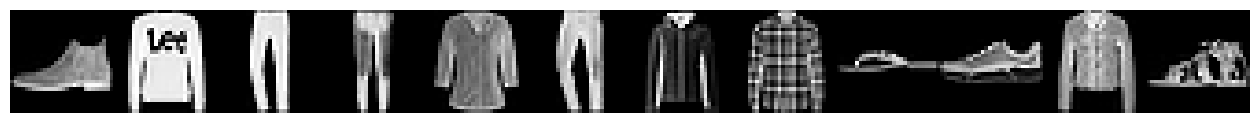

ground truth label:
[np.str_('ank boot'), np.str_('pullover'), np.str_('trouser'), np.str_('trouser'), np.str_('shirt'), np.str_('trouser'), np.str_('coat'), np.str_('shirt'), np.str_('sandal'), np.str_('sneaker'), np.str_('coat'), np.str_('sandal')]


In [ ]:
print('Visualization of first %d samples' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(input_sample, cmap='gray')
plt.axis('off')
plt.show()

print('ground truth label:')
print(list(label_selected[:num_visualize]))

Visualization of first 12 reconstructed samples for standard AE


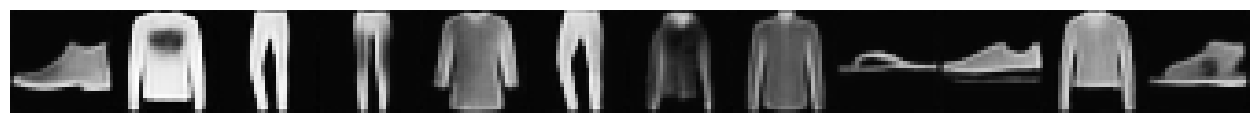

Standard-AE-Classifier prediction:
[np.str_('ank boot'), np.str_('pullover'), np.str_('trouser'), np.str_('trouser'), np.str_('shirt'), np.str_('trouser'), np.str_('coat'), np.str_('shirt'), np.str_('sandal'), np.str_('sneaker'), np.str_('coat'), np.str_('sandal')]


In [ ]:
print('Visualization of first %d reconstructed samples for standard AE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(reconst_stae, cmap='gray')
plt.axis('off')
plt.show()

print('Standard-AE-Classifier prediction:')
print(list(stae_pred[:num_visualize]))

Visualization of first 12 reconstructed samples for VAE


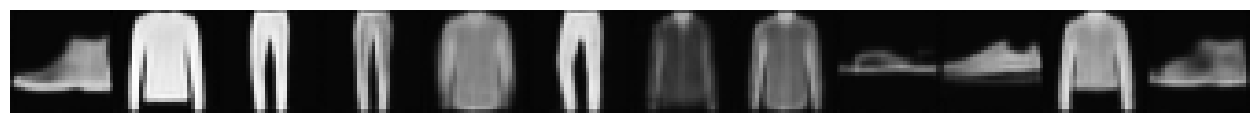

VAE-Classifier prediction:
[np.str_('ank boot'), np.str_('pullover'), np.str_('trouser'), np.str_('trouser'), np.str_('shirt'), np.str_('trouser'), np.str_('coat'), np.str_('shirt'), np.str_('sandal'), np.str_('sneaker'), np.str_('coat'), np.str_('sandal')]


In [ ]:
print('Visualization of first %d reconstructed samples for VAE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(reconst_vae, cmap='gray')
plt.axis('off')
plt.show()

print('VAE-Classifier prediction:')
print(list(vae_pred[:num_visualize]))

# Adversarial Examples

**PGD Attack (default)**

In [ ]:
adv_vae = pgd_linf(images, labels, vae_classifier, atk_itr=200, eps=50/255, alpha=2/255, device=device)
adv_stae = pgd_linf(images, labels, stae_classifier, atk_itr=200, eps=50/255, alpha=2/255, device=device)

**Attack Method Extensions**

Below are the four attack methods we implemented. To run them, comment out the default PGD attack above and uncomment the calls to the attack methods you want to experiment with.

In [ ]:
# 1) FGSM (single-step L_inf)
# adv_vae = fgsm_linf(images, labels, vae_classifier, eps=50/255, device=device)
# adv_stae = fgsm_linf(images, labels, stae_classifier, eps=50/255, device=device)


# 2) BIM / Iterative-FGSM (multi-step L_inf, like PGD but without random start)
# adv_vae = bim_linf(images, labels, vae_classifier, atk_itr=200, eps=50/255, alpha=2/255, device=device)
# adv_stae = bim_linf(images, labels, stae_classifier, atk_itr=200, eps=50/255, alpha=2/255, device=device)


# 3) PGD with random start (PGD-RS; multi-step L_inf with random init)
# adv_vae = pgd_linf_rs(images, labels, vae_classifier, atk_itr=200, eps=50/255, alpha=2/255, device=device)
# adv_stae = pgd_linf_rs(images, labels, stae_classifier, atk_itr=200, eps=50/255, alpha=2/255, device=device)


# 4) FGSM-L2 (single-step, L2-constrained approximate)
# Note: for L2 attacks the eps scale is different (uses eps_L2 = 0.5 here)
# adv_vae = fgsm_l2(images, labels, vae_classifier, eps=0.5, device=device)
# adv_stae = fgsm_l2(images, labels, stae_classifier, eps=0.5, device=device)


In [ ]:
print('L_inf of adv perturbation:')
print('Standard-AE:', torch.max(torch.abs(images - adv_stae)).cpu().numpy())
print('VAE:', torch.max(torch.abs(images - adv_vae)).cpu().numpy())

L_inf of adv perturbation:
Standard-AE: 0.18367779
VAE: 0.16191411


In [ ]:
with torch.no_grad():
    x_reconst_vae, z, y_pred_vae, mu, log_var = vae_classifier(adv_vae, deterministic=True, classification_only=False)
    x_reconst_stae, z, y_pred_stae = stae_classifier(adv_stae, classification_only=False)

label_selected, vae_pred, stae_pred = pred2label(y_pred_vae, y_pred_stae, labels)
input_adv_sample_vae, reconst_vae, _ = top_k_vis(num_visualize, adv_vae, x_reconst_vae, x_reconst_stae)
input_adv_sample_stae, _, reconst_stae = top_k_vis(num_visualize, adv_stae, x_reconst_vae, x_reconst_stae)

Accuracy of the selected batch
Accuracy of Standard-AE-Classifier: 0.544921875
Accuracy of VAE-Classifier: 0.6142578125


Visualization of first 12 adversarial samples for ST-AE


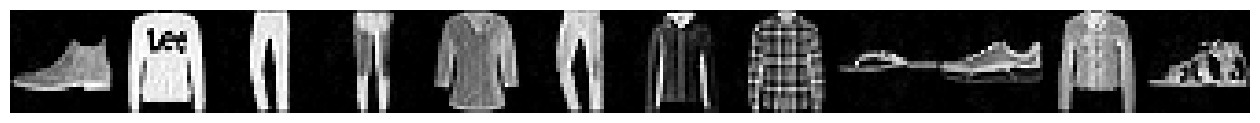

Reconstruction of Standard-AE-Classifier:


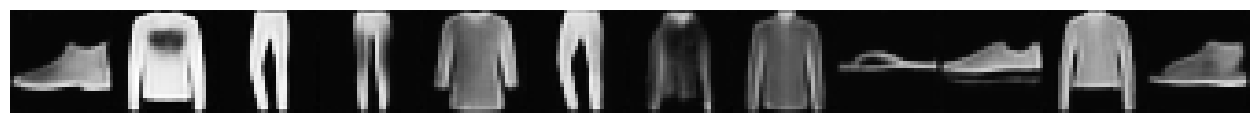

ground truth label:
[np.str_('ank boot'), np.str_('pullover'), np.str_('trouser'), np.str_('trouser'), np.str_('shirt'), np.str_('trouser'), np.str_('coat'), np.str_('shirt'), np.str_('sandal'), np.str_('sneaker'), np.str_('coat'), np.str_('sandal')]
Standard-AE-Classifier prediction:
[np.str_('ank boot'), np.str_('coat'), np.str_('trouser'), np.str_('trouser'), np.str_('top'), np.str_('trouser'), np.str_('coat'), np.str_('coat'), np.str_('sandal'), np.str_('sneaker'), np.str_('shirt'), np.str_('sandal')]


In [ ]:
print('Visualization of first %d adversarial samples for ST-AE' % (num_visualize))

plt.figure(figsize=(16,10))
plt.imshow(input_adv_sample_stae, cmap='gray')
plt.axis('off')
plt.show()

print('Reconstruction of Standard-AE-Classifier:')
plt.figure(figsize=(16,10))
plt.imshow(reconst_stae, cmap='gray')
plt.axis('off')
plt.show()

print('ground truth label:')
print(list(label_selected[:num_visualize]))

print('Standard-AE-Classifier prediction:')
print(list(stae_pred[:num_visualize]))

Visualization of first 12 adversarial samples for VAE


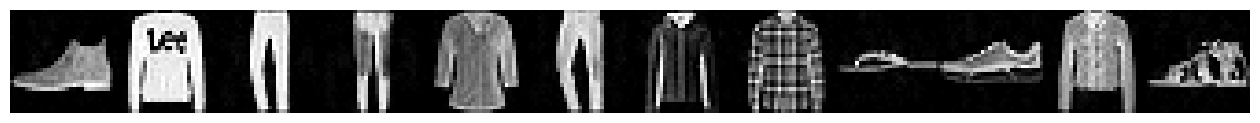

Reconstruction of VAE-Classifier:


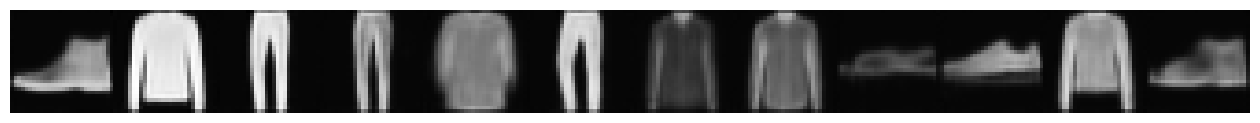

ground truth label:
[np.str_('ank boot'), np.str_('pullover'), np.str_('trouser'), np.str_('trouser'), np.str_('shirt'), np.str_('trouser'), np.str_('coat'), np.str_('shirt'), np.str_('sandal'), np.str_('sneaker'), np.str_('coat'), np.str_('sandal')]
VAE-Classifier prediction:
[np.str_('ank boot'), np.str_('pullover'), np.str_('trouser'), np.str_('trouser'), np.str_('shirt'), np.str_('trouser'), np.str_('coat'), np.str_('shirt'), np.str_('sandal'), np.str_('sneaker'), np.str_('shirt'), np.str_('sandal')]


In [ ]:
print('Visualization of first %d adversarial samples for VAE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(input_adv_sample_vae, cmap='gray')
plt.axis('off')
plt.show()

print('Reconstruction of VAE-Classifier:')
plt.figure(figsize=(16,10))
plt.imshow(reconst_vae, cmap='gray')
plt.axis('off')
plt.show()

print('ground truth label:')
print(list(label_selected[:num_visualize]))

print('VAE-Classifier prediction:')
print(list(vae_pred[:num_visualize]))

# Purified Examples

In [ ]:
purify_data_vae = vae_purify(adv_vae, vae_classifier, atk_itr=96, eps=50/255, random_iteration=3, device=device)
purify_data_stae = stae_purify(adv_stae, stae_classifier, atk_itr=96, eps=50/255, random_iteration=3, device=device)

In [ ]:
print('L_inf of purification:')
print('Standard-AE:', torch.max(torch.abs(purify_data_stae - adv_stae)).cpu().numpy())
print('VAE:', torch.max(torch.abs(purify_data_vae - adv_vae)).cpu().numpy())

L_inf of purification:
Standard-AE: 0.19607845
VAE: 0.19607845


In [ ]:
with torch.no_grad():
    x_reconst_vae, z, y_pred_vae, mu, log_var = vae_classifier(purify_data_vae, deterministic=True, classification_only=False)
    x_reconst_stae, z, y_pred_stae = stae_classifier(purify_data_stae, classification_only=False)

label_selected, vae_pred, stae_pred = pred2label(y_pred_vae, y_pred_stae, labels)
input_pfy_sample_vae, reconst_vae, _ = top_k_vis(num_visualize, purify_data_vae, x_reconst_vae, x_reconst_stae)
input_pfy_sample_stae, _, reconst_stae = top_k_vis(num_visualize, purify_data_stae, x_reconst_vae, x_reconst_stae)

Accuracy of the selected batch
Accuracy of Standard-AE-Classifier: 0.791015625
Accuracy of VAE-Classifier: 0.763671875


Visualization of first 12 adversarial samples for ST-AE


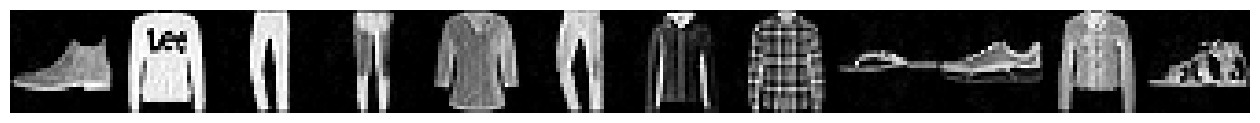

Visualization of first 12 purified samples for ST-AE


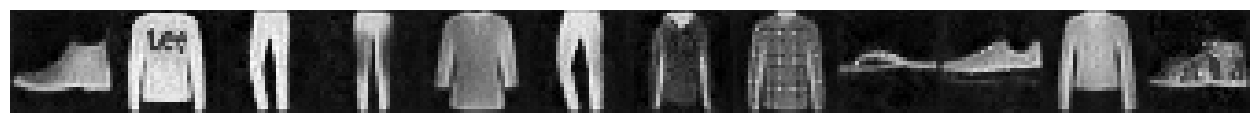

Reconstruction of Standard-AE-Classifier:


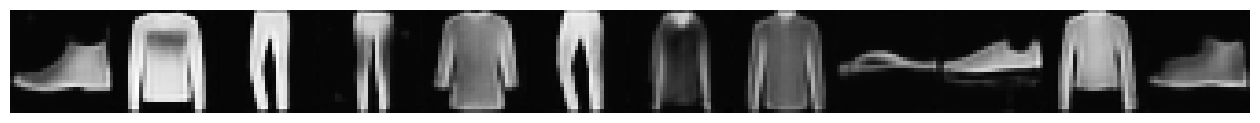

ground truth label:
[np.str_('ank boot'), np.str_('pullover'), np.str_('trouser'), np.str_('trouser'), np.str_('shirt'), np.str_('trouser'), np.str_('coat'), np.str_('shirt'), np.str_('sandal'), np.str_('sneaker'), np.str_('coat'), np.str_('sandal')]
Standard-AE-Classifier prediction:
[np.str_('ank boot'), np.str_('pullover'), np.str_('trouser'), np.str_('trouser'), np.str_('shirt'), np.str_('trouser'), np.str_('coat'), np.str_('shirt'), np.str_('sandal'), np.str_('sneaker'), np.str_('shirt'), np.str_('ank boot')]


In [ ]:
print('Visualization of first %d adversarial samples for ST-AE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(input_adv_sample_stae, cmap='gray')
plt.axis('off')
plt.show()

print('Visualization of first %d purified samples for ST-AE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(input_pfy_sample_stae, cmap='gray')
plt.axis('off')
plt.show()

print('Reconstruction of Standard-AE-Classifier:')
plt.figure(figsize=(16,10))
plt.imshow(reconst_stae, cmap='gray')
plt.axis('off')
plt.show()

print('ground truth label:')
print(list(label_selected[:num_visualize]))
print('Standard-AE-Classifier prediction:')
print(list(stae_pred[:num_visualize]))

Visualization of first 12 adversarial samples for VAE


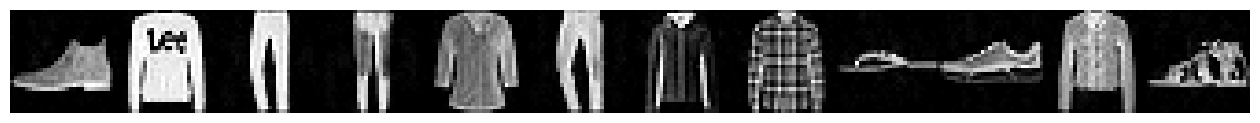

Visualization of first 12 purified samples for VAE


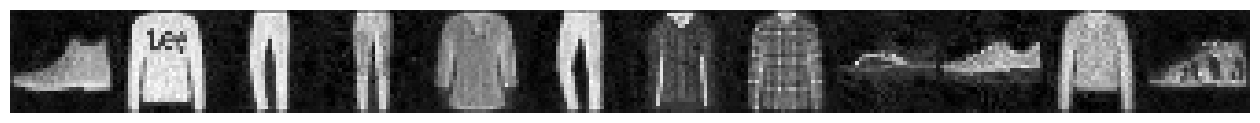

Reconstruction of VAE-Classifier:


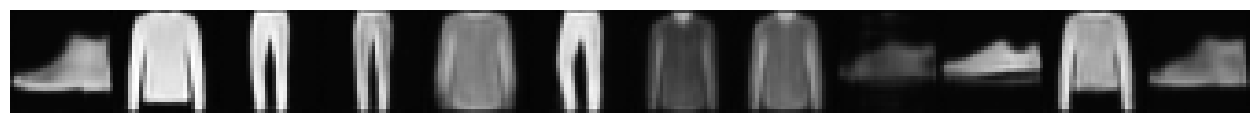

ground truth label:
[np.str_('ank boot'), np.str_('pullover'), np.str_('trouser'), np.str_('trouser'), np.str_('shirt'), np.str_('trouser'), np.str_('coat'), np.str_('shirt'), np.str_('sandal'), np.str_('sneaker'), np.str_('coat'), np.str_('sandal')]
VAE-Classifier prediction:
[np.str_('ank boot'), np.str_('pullover'), np.str_('trouser'), np.str_('trouser'), np.str_('pullover'), np.str_('trouser'), np.str_('shirt'), np.str_('shirt'), np.str_('sandal'), np.str_('sneaker'), np.str_('pullover'), np.str_('sandal')]


In [ ]:
print('Visualization of first %d adversarial samples for VAE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(input_adv_sample_vae, cmap='gray')
plt.axis('off')
plt.show()

print('Visualization of first %d purified samples for VAE' % (num_visualize))
plt.figure(figsize=(16,10))
plt.imshow(input_pfy_sample_vae, cmap='gray')
plt.axis('off')
plt.show()

print('Reconstruction of VAE-Classifier:')
plt.figure(figsize=(16,10))
plt.imshow(reconst_vae, cmap='gray')
plt.axis('off')
plt.show()

print('ground truth label:')
print(list(label_selected[:num_visualize]))
print('VAE-Classifier prediction:')
print(list(vae_pred[:num_visualize]))